# Aula 01 - Parte 2
## Modelo de Câmera e Matriz de Projeção

Nesta segunda parte da aula introduziremos o modelo de câmera pinhole e conceitos básicos de geometria projetiva. Para isso vamos implementar um renderizador simples de imagens, que recebe as coordenadas de vértices em 3D e calcula a sua posição na imagem de uma câmera, em 2D.

Uma explicação interessante sobre a matriz da câmera pode ser encontrada aqui: http://ksimek.github.io/2012/08/14/decompose/

### O formato .OBJ

O formato [.OBJ](https://en.wikipedia.org/wiki/Wavefront_.obj_file) é uma maneira simples de armazenar dados de um objeto 3D de forma legível tanto para o computador quanto para seres humanos. Como o nosso objetivo não é nos aprofundarmos em computação gráfica, utilizaremos somente uma parte da informação armazenada no arquivo .OBJ, as coordenadas dos vértices em 3D.

Para carregar um arquivo .OBJ no Python instale a biblioteca *PyWavefront* com o comando:

    pip install PyWavefront


In [1]:
# Imports
import pywavefront
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Para plotar em 3D
import matplotlib.pyplot as plt
import math
import cv2

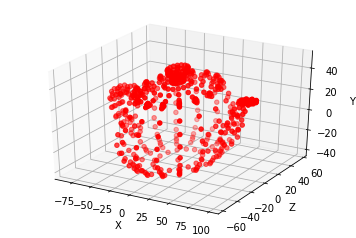

In [2]:
# Carregando as coordenadas dos vértices
scene = pywavefront.Wavefront('teapot.obj')
vertices = np.array(scene.vertices)
# Transforma para coordenadas homogêneas
vertices = np.hstack((vertices, np.ones(shape=(len(vertices), 1))))
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

# Visualizando...
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, z, y, c='r', marker='o')  # Trocamos o y e o z só para facilitar a visualização
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

## Atividade

Sua tarefa é gerar um vídeo como o apresentado a seguir. Para isso você deve entender os seguintes conceitos:

1. Coordenadas homogêneas
2. Matrizes de transformação linear (rotação, translação e escala)
3. Modelo de câmera pinhole
4. Matriz de parâmetros intrínsecos e extrínsecos da câmera

### Dependências

Para visualizar o vídeo no jupyter notebook você vai precisar da biblioteca *cvloop*. Você pode instalá-la utilizando o *pip*:

    pip install cvloop

<IPython.core.display.Javascript object>


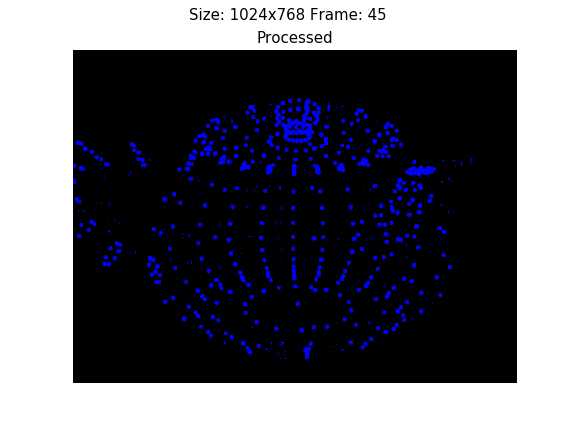

In [4]:
from cvloop import cvloop
cvloop('teapot.mp4')

### Ideia geral

A cena é gerada rotacionando a câmera ao redor do objeto. Assumindo que a câmera está fixa na origem isso é o mesmo que rotacionar o mundo (todos os objetos menos a câmera) ao redor da câmera no sentido oposto.

#### Sugestão de passos para pensar e resolver o problema

1. Os parâmetros intrínsecos da câmera não mudam, independente da sua posição. Comece gerando a matriz de parâmetros intrínsecos e testando a projeção com alguns pontos conhecidos, por exemplo, um ponto centralizado no eixo ótico da câmera: (0, 0, 10). Você pode utilizar os parâmetros intrínsecos da câmera sugeridos abaixo, mas sugiro testarem outros valores para entender o impacto de cada um deles. **Atenção:** não se esqueça que o ponto é representado em coordenadas homogêneas, então você sempre deve aplicar uma normalização antes de utilizar as coordenadas $x$ e $y$.
2. Através do plot dos vértices é possível observar que o centro do objeto é aproximadamente na origem. A câmera também está originalmente na origem. Como queremos capturar a imagem na câmera de fora do objeto, devemos aplicar uma translação para mover a câmera ou o objeto. Tente gerar uma única imagem do objeto com essa câmera transladada (no eixo Z, por exemplo). Para isso, basta percorrer a lista de vértices e calcular a sua projeção na imagem da câmera.
    1. Gere uma imagem com todos os pixels pretos
    2. Para cada ponto projetado, desenhe um círculo na imagem preta utilizando o OpenCV
3. Pesquise como gerar um vídeo usando o OpenCV.
4. Para gerar cada um dos frames a partir da nova posição você deve aplicar uma rotação. **Atenção:** a ordem das transformações importa. Aplicar primeiro a translação e depois a rotação é diferente de aplicar a rotação e depois a translação. O mais simples seria aplicar uma rotação ao redor do eixo vertical (Y).

    Para gerar cada frame desse vídeo você deve:

    1. Gerar uma matriz de transformação com os parâmetros extrínsecos da câmera
    2. Aplicar a projeção para cada vértice do objeto (utilizando os parâmetros intrínsecos e extrínsecos)
    3. Desenhar os pontos na imagem

##### Sugestão de parâmetros intrínsecos da câmera

- $f_x = f_y = 500$ px
- Largura do sensor: 1024 px
- Altura do sensor: 768 px
- Ponto principal: centro do sensor

## Desafios

1. Faça com que a cor de cada vértice dependa da sua distância até a câmera: quanto mais próximo, mais claro e quanto mais distante, mais escuro.
2. Implemente um movimento mais complexo para a câmera. Para isso uma possibilidade é escolher parâmetros iniciais e finais e interpolar os valores intermediários, renderizando frames para cada valor intermediário.
3. Utilize outros objetos 3D. Você pode encontrar outros exemplos de arquivos .OBJ na internet, ou exportar um modelo 3D para esse arquivo (boa parte dos programas de modelagem 3D sabe exportar para .OBJ).
4. Renderize também as faces dos objetos e não somente os vértices. Para isso você deverá ordenar as faces por distância antes de renderizar.
5. Pesquise sobre e implemente a distorção causada pelas lentes.

### Passo 1
1. Os parâmetros intrínsecos da câmera não mudam, independente da sua posição. Comece gerando a matriz de parâmetros intrínsecos e testando a projeção com alguns pontos conhecidos, por exemplo, um ponto centralizado no eixo ótico da câmera: (0, 0, 10). Você pode utilizar os parâmetros intrínsecos da câmera sugeridos abaixo, mas sugiro testarem outros valores para entender o impacto de cada um deles. **Atenção:** não se esqueça que o ponto é representado em coordenadas homogêneas, então você sempre deve aplicar uma normalização antes de utilizar as coordenadas $x$ e $y$.

In [5]:
def translation_matrix(tx, ty, tz):
    m = np.eye(4)
    m[0][3] = tx
    m[1][3] = ty
    m[2][3] = tz
    return m
tr = translation_matrix(0,0,10)
tr

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., 10.],
       [ 0.,  0.,  0.,  1.]])

In [6]:
width = 1024
height = 768
fx = fy = 500
px = int(width/2)
py = int(height/2)

def criar_mcamera(fx, fy, px, py):
    cam_m = np.array([[fx, 0, px, 0],[0, fy, py, 0],[0,0,1,0]])
    return cam_m

cam_m = criar_mcamera(fx, fy, px, py)
print(cam_m)
    
def testar_mcamera(ponto):
    res = cam_m @ ponto
    normalizado = res//res[2]
    print(normalizado.astype(int))
    return normalizado

[[500   0 512   0]
 [  0 500 384   0]
 [  0   0   1   0]]


In [7]:
testar_mcamera([0,0,10,1])
testar_mcamera([0,5,10,1])
testar_mcamera([0,-5,10,1])
testar_mcamera([5,0,10,1])
testar_mcamera([10,0,10,1])

[512 384   1]
[512 634   1]
[512 134   1]
[762 384   1]
[1012  384    1]


array([1012,  384,    1])

### Passo 2
Através do plot dos vértices é possível observar que o centro do objeto é aproximadamente na origem. A câmera também está originalmente na origem. Como queremos capturar a imagem na câmera de fora do objeto, devemos aplicar uma translação para mover a câmera ou o objeto. Tente gerar uma única imagem do objeto com essa câmera transladada (no eixo Z, por exemplo). Para isso, basta percorrer a lista de vértices e calcular a sua projeção na imagem da câmera.
- A: Gere uma imagem com todos os pixels pretos
- B: Para cada ponto projetado, desenhe um círculo na imagem preta utilizando o OpenCV

In [8]:
def calcular_projecao(ponto, cam_m, tz):
    ci = cam_m
    ce = translation_matrix(0,0, tz)
    pi = ponto
    
    projecao = ci @ (ce @ pi)
    projecao /= projecao[2]
    return projecao

In [9]:
projecao = []

for ponto in vertices:
    projecao.append(calcular_projecao(ponto, cam_m, 100))

<IPython.core.display.Javascript object>


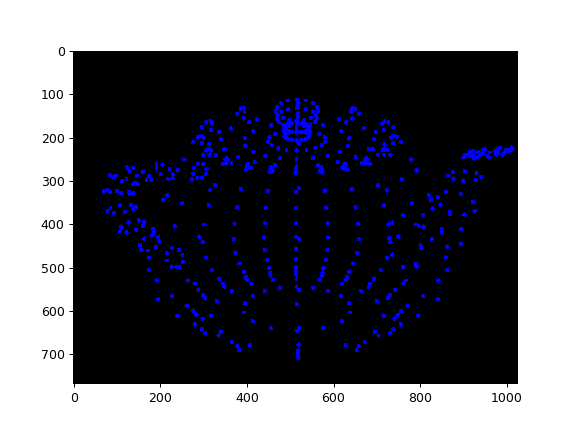

In [11]:
black_image = np.zeros((height, width, 3), dtype = np.uint8)
for ponto in projecao:
    cv2.circle(black_image,(int(ponto[0]),height-int(ponto[1])), 5, (0,0,255), -1)
plt.imshow(black_image)
plt.show()

### Passo 3 e 4
3. Pesquise como gerar um vídeo usando o OpenCV.
4. Para gerar cada um dos frames a partir da nova posição você deve aplicar uma rotação. **Atenção:** a ordem das transformações importa. Aplicar primeiro a translação e depois a rotação é diferente de aplicar a rotação e depois a translação. O mais simples seria aplicar uma rotação ao redor do eixo vertical (Y).

    Para gerar cada frame desse vídeo você deve:

    1. Gerar uma matriz de transformação com os parâmetros extrínsecos da câmera
    2. Aplicar a projeção para cada vértice do objeto (utilizando os parâmetros intrínsecos e extrínsecos)
    3. Desenhar os pontos na imagem

In [12]:
##Iniciando variáveis para vídeo

# Carregando as coordenadas dos vértices
scene = pywavefront.Wavefront('teapot.obj')
vertices = np.array(scene.vertices)
vertices = np.hstack((vertices, np.ones(shape=(len(vertices), 1))))

#Criando matriz de câmera
cam_m = criar_mcamera(fx, fy, px, py)

# Largura e Altura
width = 1024
height = 768

In [13]:
def rotation_matrix(theta):
    #É uma matriz diferente, se nao gira no sentido anti-horário
    m = np.eye(4)
    m[0][0] = math.cos(theta)
    m[0][2] = -math.sin(theta)
    m[2][0] = math.sin(theta)
    m[2][2] = math.cos(theta)
    return m

In [14]:
def calcular_projecao_video(vertices, cam_m, theta, tz):
    resultado = []
    
    ci = cam_m
    ce = translation_matrix(0,0, tz) @ rotation_matrix(theta)
    for ponto in vertices:
        pi = ponto
        
        projecao = ci @ (ce @ pi)
        projecao /= projecao[2]
        
        resultado.append(projecao)

    return resultado

def criar_video(vertices, cam_m, height, width):
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (width,height))

    for theta in np.arange(0, 2*math.pi, 0.01):
        imagem = np.zeros((height, width, 3), dtype = np.uint8)
        projecao = calcular_projecao_video(vertices, cam_m, theta, 120)
        for ponto in projecao:
            cv2.circle(imagem,(int(ponto[0]),height-int(ponto[1])), 5, (255,0,0), -1)
        out.write(imagem)
    out.release()

In [15]:
criar_video(vertices, cam_m, height, width)

<IPython.core.display.Javascript object>


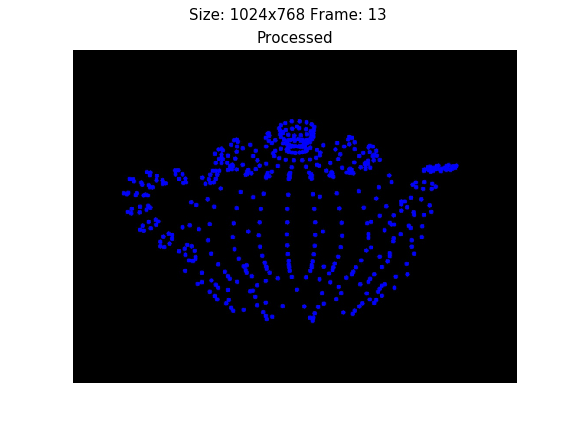

In [17]:
cvloop('output.avi')